# Polygonal search

This notebook performs a performance comparison between [`spherical-geometry`](https://github.com/spacetelescope/spherical_geometry) and [`sphgeom`](https://github.com/lsst/sphgeom) for catalog polygonal searches. For that we load a small test catalog and upsample the data to get about 100 000 points (close to what we would find in a real partition).

In [1]:
import lsdb
import numpy as np

TOTAL_NUM_POINTS = 100_000

catalog = lsdb.read_hipscat("../../tests/data/small_sky_order1").compute()

### Defining the polygon sky coordinates

In [2]:
polygon_ra, polygon_dec = [300, 300, 272, 272], [-50, -55, -55, -50]
coordinates = np.array([polygon_ra, polygon_dec]).T

### Upsample points in test dataset for stress testing

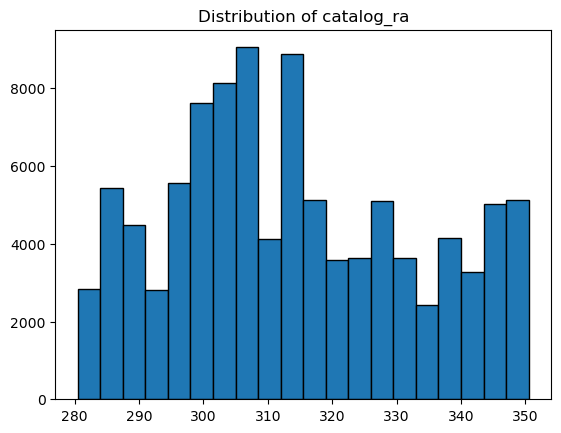

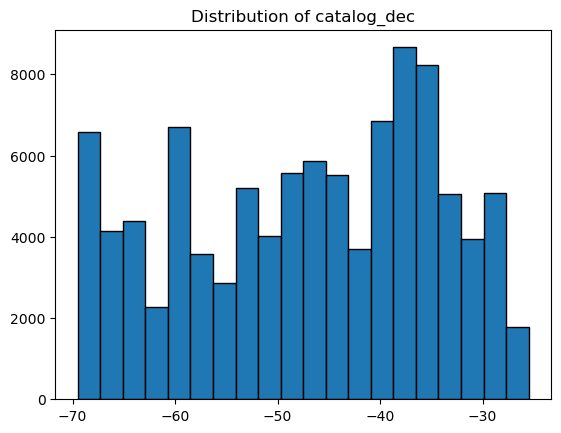

In [3]:
import matplotlib.pyplot as plt

def upsample_array(input_array, num_points=TOTAL_NUM_POINTS):
    if num_points <= len(input_array):
        return input_array
    original_points = np.arange(len(input_array))
    upsampled_points = np.linspace(0, len(input_array) - 1, num_points)
    upsampled_array = np.interp(upsampled_points, original_points, input_array)
    return upsampled_array

def plot_coordinates_distribution(catalog_ra, catalog_dec):
    plt.figure()
    plt.hist(catalog_ra, bins=20, edgecolor='black')
    plt.title("Distribution of catalog_ra")
    plt.figure()
    plt.hist(catalog_dec, bins=20, edgecolor='black')
    plt.title("Distribution of catalog_dec")
    plt.show()

catalog_ra = upsample_array(catalog["ra"].values)
catalog_dec = upsample_array(catalog["dec"].values)
plot_coordinates_distribution(catalog_ra, catalog_dec)

### Option 1: Filter using `spherical-geometry`

This package allows filtering with convex and non-convex polygons but, unfortunately, the operation is not vectorized.

In [4]:
from spherical_geometry.polygon import SingleSphericalPolygon
polygon = SingleSphericalPolygon.from_lonlat(polygon_ra, polygon_dec)

In [5]:
%%time
result_option1 = [polygon.contains_lonlat(ra, dec) for ra, dec in zip(catalog_ra, catalog_dec)]

CPU times: user 5.6 s, sys: 2.57 ms, total: 5.6 s
Wall time: 5.21 s


### Option 2: Filter using `sphgeom`

This package is built in C++ with bindings to Python. The `contains` operation is vectorized and, therefore, incredibly fast.

In [6]:
from lsst.sphgeom import UnitVector3d, ConvexPolygon, LonLat
vertice_vectors = [UnitVector3d(LonLat.fromDegrees(lon,lat)) for lon,lat in coordinates]
polygon = ConvexPolygon(vertice_vectors)
# polygon.contains uses radians instead of degrees
catalog_ra_radians = np.radians(catalog_ra)
catalog_dec_radians = np.radians(catalog_dec)

In [7]:
%%time
result_option2 = polygon.contains(catalog_ra_radians, catalog_dec_radians)

CPU times: user 2.79 ms, sys: 5 µs, total: 2.79 ms
Wall time: 2.8 ms


In [8]:
# The filtered points on the test scenario match
assert (result_option1 == result_option2).all()